In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import threading
import queue
import concurrent.futures
import gc

In [2]:

# Load the data
df = pd.read_csv('datasets/data.csv', sep=';', index_col='Row')
df.head(3)

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20,Unnamed: 22,Unnamed: 23
Row,,,,,,,,,,,,,,,,,,,,,
0,"0,750000",1,0,1,1,1,1,1,0,1,...,1,1,1,"0,001132","0,080780","0,197324","0,300926","0,225000",NaN,NaN
1,"0,239583",1,1,1,1,1,1,1,1,1,...,1,1,1,"0,000472","0,164345","0,235786","0,537037","0,165625",NaN,NaN
2,"0,479167",1,1,1,1,1,1,1,1,1,...,1,1,1,"0,003585","0,130919","0,167224","0,527778","0,118750",NaN,NaN


In [3]:
def PCA_tSNE_visualization(data2visualize, NCOMP, LABELS, PAL='viridis'):

  '''
  INPUT
  data2visualize    - data matrix to visualize
  NCOMP             - no. of components to decompose the dataset during PCA
  LABELS            - labels given by the clustering solution
  PAL               - palette of colours to distinguish between clusters
  '''

  '''
  OUTPUT
  Two figures: one using PCA and one using tSNE
  '''


  # PCA
  from sklearn.decomposition import PCA
  pca = PCA(n_components=NCOMP)
  pca_result = pca.fit_transform(data2visualize)
  print('PCA: explained variation per principal component: {}'.format(pca.explained_variance_ratio_.round(2)))

  # tSNE
  from sklearn.manifold import TSNE
  print('\nApplying tSNE...')
  np.random.seed(100)
  tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=300)
  tsne_results = tsne.fit_transform(data2visualize)


  # Plots
  fig1000 = plt.figure(figsize=(10,5))
  fig1000.suptitle('Dimensionality reduction of the dataset', fontsize=16)


  # Plot 1: 2D image of the entire dataset
  ax1 = fig1000.add_subplot(121)
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
  ax1.set_xlabel('Dimension 1', fontsize=10)
  ax1.set_ylabel('Dimension 2', fontsize=10)
  ax1.title.set_text('PCA')
  plt.grid()

  ax2= fig1000.add_subplot(122)
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)
  ax2.set_xlabel('Dimension 1', fontsize=10)
  ax2.set_ylabel('Dimension 2', fontsize=10)
  ax2.title.set_text('tSNE')
  plt.grid()
  plt.show()

# Data cleaning

In [4]:
# change the data type of the columns to float

df = df.replace(',', '.', regex=True)
df.drop(['Unnamed: 22', 'Unnamed: 23'], axis=1, inplace=True)
df.head(3)

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_11=0,Dim_12=0,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20
Row,,,,,,,,,,,,,,,,,,,,,
0,0.750000,1,0,1,1,1,1,1,0,1,...,1,1,1,1,1,0.001132,0.080780,0.197324,0.300926,0.225000
1,0.239583,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0.000472,0.164345,0.235786,0.537037,0.165625
2,0.479167,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0.003585,0.130919,0.167224,0.527778,0.118750


In [5]:
# convert 0-1 columns to boolean
int_cols = df.select_dtypes(include=['int64']).columns
# convert to bool if the column has only 0 and 1
for col in int_cols:
    if df[col].nunique() == 2:
        df[col] = df[col].astype(bool)
df.dtypes

Dim_0       object
Dim_1=0       bool
Dim_2=0       bool
Dim_3=0       bool
Dim_4=0       bool
Dim_5=0       bool
Dim_6=0       bool
Dim_7=0       bool
Dim_8=0       bool
Dim_9=0       bool
Dim_10=0      bool
Dim_11=0      bool
Dim_12=0      bool
Dim_13=0      bool
Dim_14=0      bool
Dim_15=0      bool
Dim_16      object
Dim_17      object
Dim_18      object
Dim_19      object
Dim_20      object
dtype: object

In [6]:
bool_cols = df.select_dtypes(include=['bool']).columns
df.head(3)

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_11=0,Dim_12=0,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20
Row,,,,,,,,,,,,,,,,,,,,,
0,0.750000,True,False,True,True,True,True,True,False,True,...,True,True,True,True,True,0.001132,0.080780,0.197324,0.300926,0.225000
1,0.239583,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,0.000472,0.164345,0.235786,0.537037,0.165625
2,0.479167,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,0.003585,0.130919,0.167224,0.527778,0.118750


In [7]:
# take columns that are not boolean
float_cols = df.select_dtypes(exclude=['bool']).columns
df[float_cols] = df[float_cols].astype(float)
df.dtypes

Dim_0       float64
Dim_1=0        bool
Dim_2=0        bool
Dim_3=0        bool
Dim_4=0        bool
Dim_5=0        bool
Dim_6=0        bool
Dim_7=0        bool
Dim_8=0        bool
Dim_9=0        bool
Dim_10=0       bool
Dim_11=0       bool
Dim_12=0       bool
Dim_13=0       bool
Dim_14=0       bool
Dim_15=0       bool
Dim_16      float64
Dim_17      float64
Dim_18      float64
Dim_19      float64
Dim_20      float64
dtype: object

In [8]:
df.describe()

,Dim_0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20
count,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000
mean,0.531790,0.009172,0.108506,0.179649,0.374250,0.173773
std,0.197156,0.043357,0.042001,0.060148,0.088354,0.056402
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.375000,0.001340,0.091922,0.145485,0.324074,0.145312
50%,0.562500,0.003208,0.109192,0.175585,0.370370,0.170313
75%,0.687500,0.005094,0.119777,0.205686,0.402778,0.195313
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# check for missing values, none are found
df.isnull().sum()

Dim_0       0
Dim_1=0     0
Dim_2=0     0
Dim_3=0     0
Dim_4=0     0
Dim_5=0     0
Dim_6=0     0
Dim_7=0     0
Dim_8=0     0
Dim_9=0     0
Dim_10=0    0
Dim_11=0    0
Dim_12=0    0
Dim_13=0    0
Dim_14=0    0
Dim_15=0    0
Dim_16      0
Dim_17      0
Dim_18      0
Dim_19      0
Dim_20      0
dtype: int64

In [10]:
# scaling of float columns
scaler = StandardScaler()
df[float_cols] = scaler.fit_transform(df[float_cols])

In [11]:
# as expected the mean is (numerically) 0 and the standard deviation is (numerically) 1
df.describe()

,Dim_0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20
count,7.200000e+03,7.200000e+03,7.200000e+03,7.200000e+03,7.200000e+03,7.200000e+03
mean,8.684411e-17,-5.921189e-18,2.111891e-16,-8.092292e-17,-2.289527e-16,-3.157968e-16
std,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00
min,-2.697497e+00,-2.115708e-01,-2.583596e+00,-2.986986e+00,-4.236078e+00,-3.081162e+00
25%,-7.953142e-01,-1.806625e-01,-3.948692e-01,-5.680383e-01,-5.679310e-01,-5.046416e-01
50%,1.557775e-01,-1.375755e-01,1.634148e-02,-6.757202e-02,-4.391320e-02,-6.134996e-02
75%,7.898385e-01,-9.407336e-02,2.683777e-01,4.329109e-01,3.229083e-01,3.819239e-01
max,2.374991e+00,2.285427e+01,2.122710e+01,1.363980e+01,7.082778e+00,1.464979e+01


PCA: explained variation per principal component: [0.38 0.23]

Applying tSNE...


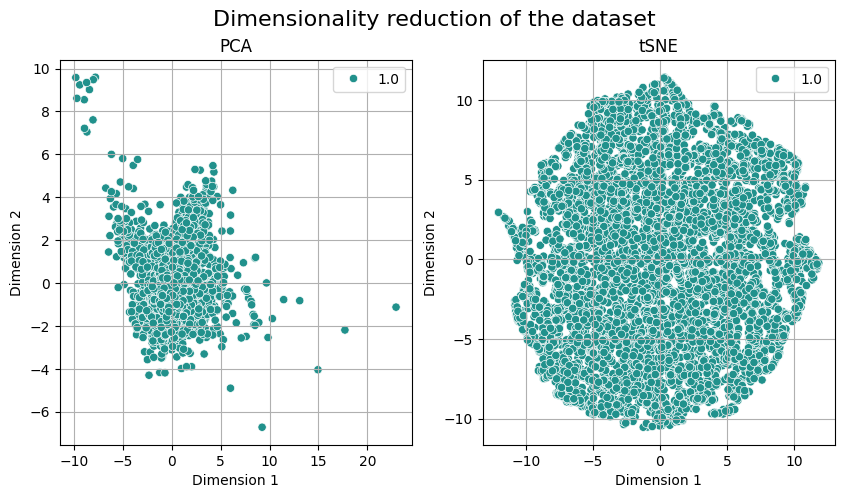

In [12]:
# PCA & tSNE floats visualization
PCA_tSNE_visualization(df[float_cols], 2, np.ones(df.shape[0]), 'viridis')

PCA: explained variation per principal component: [0.33 0.17]

Applying tSNE...


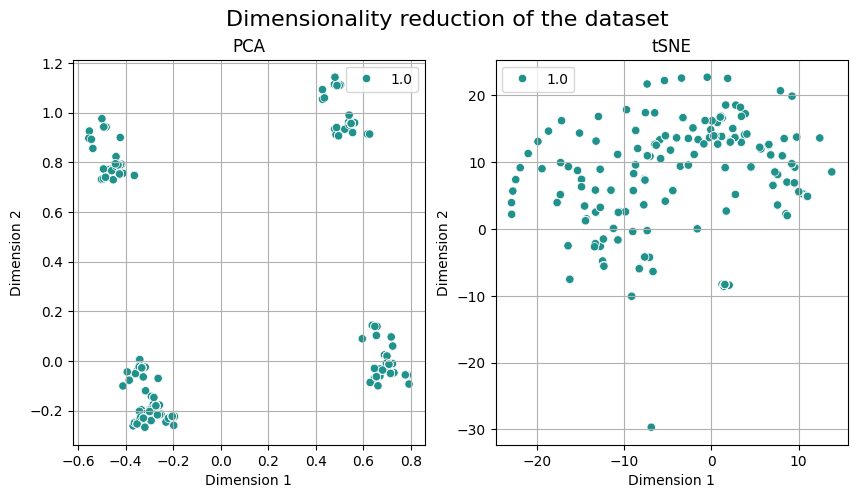

In [13]:
# PCA & tSNE bools visualization
PCA_tSNE_visualization(df[bool_cols], 2, np.ones(df.shape[0]), 'viridis')

PCA: explained variation per principal component: [0.35 0.21]

Applying tSNE...


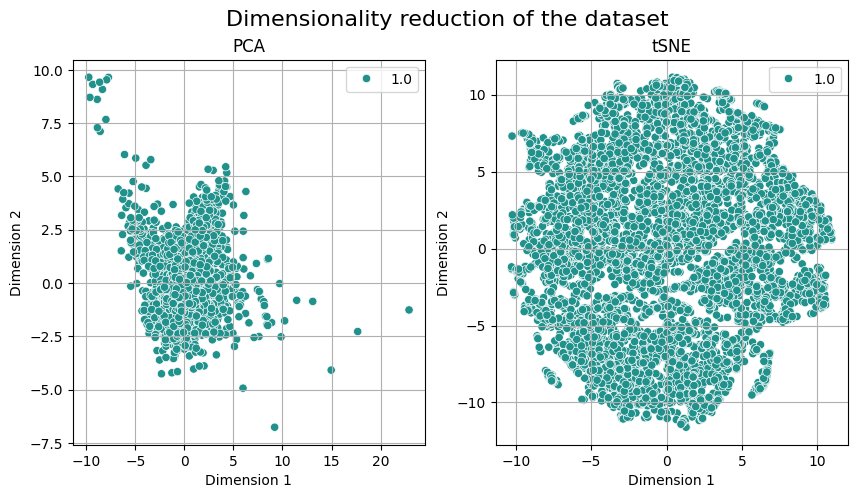

In [14]:
# the whole thing
PCA_tSNE_visualization(df, 2, np.ones(df.shape[0]), 'viridis')

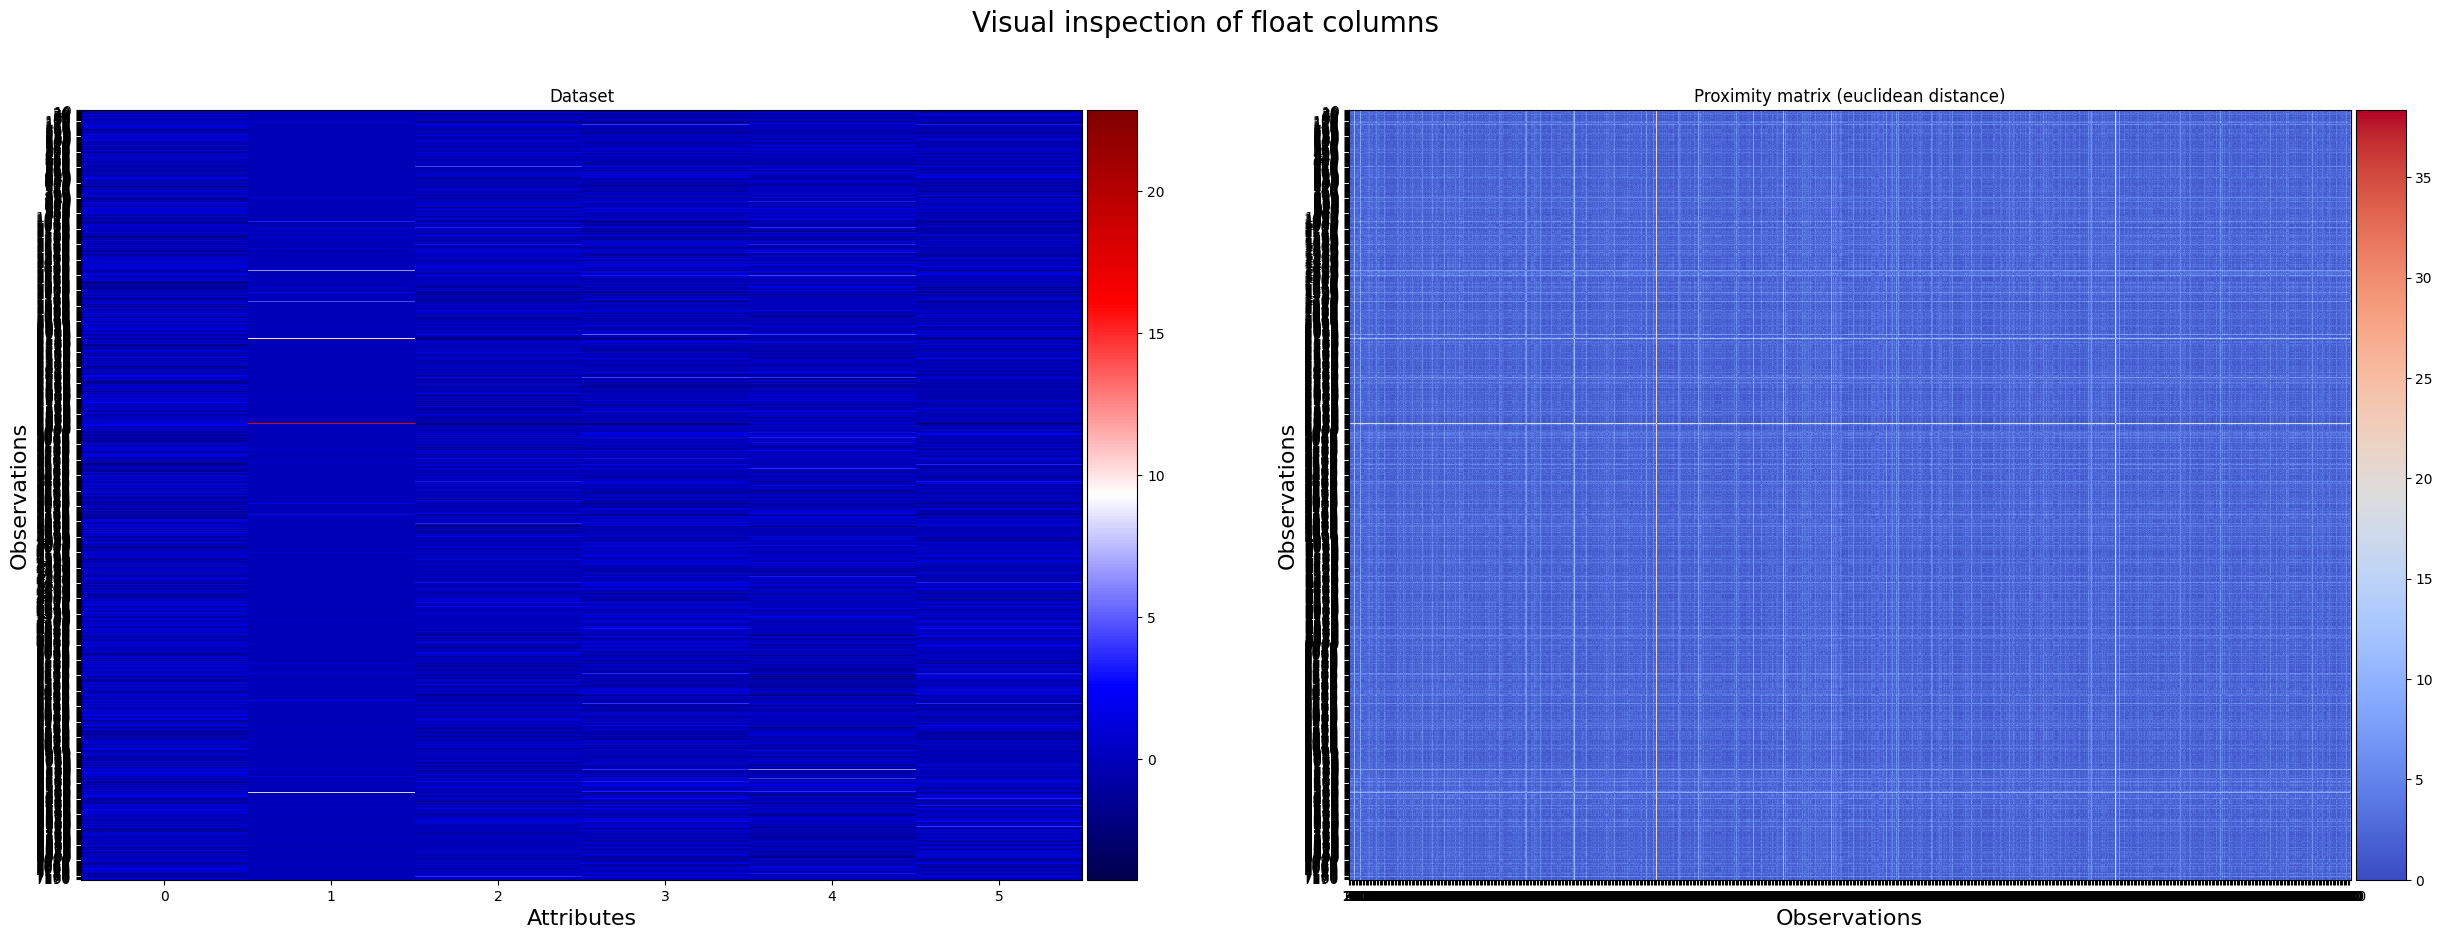

In [50]:
# Visualization
# -------------
# Choose your preferred style: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html


plt.style.use('default')

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as sf

distance_metric = 'euclidean'
PM = pdist(df[float_cols], metric=distance_metric)
PM = sf(PM).round(2)
[N,M] = np.shape(df[float_cols])

fig1 = plt.figure(figsize=(30,10))
fig1.suptitle('Visual inspection of float columns', fontsize=20)


# Plot 1: 2D image of the entire dataset
ax1 = fig1.add_subplot(121)
im1 = ax1.imshow(df[float_cols], interpolation='nearest', aspect='auto', cmap='seismic')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

ax1.set_xlabel('Attributes', fontsize=16)
ax1.set_xticks(np.arange(0, M, step=1))
ax1.set_ylabel('Observations', fontsize=16)
ax1.set_yticks(np.arange(0, N, step=10))
ax1.title.set_text('Dataset')


# Plot 2: proximity matrix
ax2 = fig1.add_subplot(122)
im2 = ax2.imshow(PM, interpolation='nearest', aspect='auto', cmap='coolwarm')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

ax2.set_xlabel('Observations', fontsize=16)
ax2.set_xticks(np.arange(0, N, step=10))
ax2.set_ylabel('Observations', fontsize=16)
ax2.set_yticks(np.arange(0, N, step=10))
ax2.title.set_text('Proximity matrix (%s distance)' % distance_metric)

plt.show()

# Anomaly detection

## Proximity Based

### Proximity Matrix for mixed data-types
We should store these functions in as a library

In [15]:
def proximity_feat(x, y, metric):
    """
    Calculate the proximity between two input vectors using the specified metric.
    This is intended to compute the proximity between two single features.
    
    Parameters:
    x (array-like): The first input vector.
    y (array-like): The second input vector.
    metric (str): The metric to use. Supported metrics are:
        - 'euclidean': Euclidean distance.
        - 'cosine': Cosine similarity.
        - 'manhattan': Manhattan distance.
        - 'jaccard': Jaccard similarity.
        - 'pearson': Pearson correlation coefficient.
        - 'spearman': Spearman correlation coefficient.
        - 'hamming': Hamming distance.

    Returns:
    float: The proximity between the two input vectors.

    Raises:
    ValueError: If the two input vectors are not of the same type.
    ValueError: If an unknown metric is specified.
    """
    if(type(x) != type(y)):
        raise ValueError(f'The two inputs must be of the same type, got {type(x)} and {type(y)}')

    if metric == 'euclidean':
        return np.linalg.norm(x - y)
    elif metric == 'cosine':
        return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
    elif metric == 'manhattan':
        return np.sum(np.abs(x - y))
    elif metric == 'jaccard':
        return 1 - np.sum(np.minimum(x, y)) / np.sum(np.maximum(x, y))
    elif metric == 'pearson':
        return np.corrcoef(x, y)[0, 1]
    elif metric == 'spearman':
        return 1 - 6 * np.sum((x - y) ** 2) / (len(x) * (len(x) ** 2 - 1))
    elif metric == 'hamming':
        return np.sum(x != y) # assuming this is a single value
    else:
        raise ValueError('Unknown metric')

In [16]:
def gower_distance(x, y, metrics, weights=None):
    """
    Calculates the overall proximity between two vectors, x and y, using a set of metrics and optional weights.

    Parameters:
    x (list): The first input vector.
    y (list): The second input vector.
    metrics (dict): A dictionary containing the metrics to be used for each type of element in the vectors. The keys represent the type of the element and the values represent the metric to be used.
    weights (list, optional): A list of weights for each element in the vectors. If not provided, all elements are assumed to have equal weight.

    Returns:
    float: The overall proximity between the two input vectors.

    Raises:
    ValueError: If the input metrics is not a non-empty dictionary or if the two input vectors have different lengths.
    ValueError: If the weights are negative.
    """
    
    if type(metrics) != dict or len(metrics) == 0:
        raise ValueError("The input metrics must be a non-empty dictionary in the form: {type: metric}") 
    if len(x) != len(y):
        raise ValueError(f'The two input vectors must have the same length found {len(x)} and {len(y)}')
    if weights is None:
        weights = np.ones_like(x)
    elif weights < 0:
        raise ValueError('The weights must be non-negative')
    
    prox = 0
    for xk, yk, wk in zip(x, y, weights):
        curr_metric = metrics[type(xk)]
        prox += wk*proximity_feat(xk, yk, curr_metric)        
    return prox/len(x)

In [17]:
def proximity_matrix_symmetric(data, metrics, weights=None):
    """
    Calculates the proximity matrix for a given dataset.

    Parameters:
    data (pandas DataFrame): The input dataset.
    metrics (dict): A dictionary containing the metrics to be used for each type of element in the vectors. The keys represent the type of the element and the values represent the metric to be used.
    weights (list, optional): A list of weights for each element in the vectors. If not provided, all elements are assumed to have equal weight.

    Returns:
    prox_matrix (numpy array): The proximity matrix, where each element represents the proximity between two data points.
    """

    prox_matrix = np.zeros((data.shape[0], data.shape[0]))
    for i in tqdm(range(data.shape[0]), desc='Computing proximity matrix'):
        for j in range(i, data.shape[0]): # since the matrix is symmetric we start from i, computing the upper triangle
            prox_matrix[i, j] = gower_distance(data.iloc[i], data.iloc[j], metrics, weights)
            prox_matrix[j, i] = prox_matrix[i, j]
    return prox_matrix

In [18]:
def proximity_matrix_asymmetric(data1, data2, metrics, weights=None):
    """
    Calculates the proximity matrix between two datasets.

    Parameters:
    data1 (pandas DataFrame): The first input dataset.
    data2 (pandas DataFrame): The second input dataset.
    metrics (dict): A dictionary containing the metrics to be used for each type of element in the vectors. The keys represent the type of the element and the values represent the metric to be used.
    weights (list, optional): A list of weights for each element in the vectors. If not provided, all elements are assumed to have equal weight.

    Returns:
    prox_matrix (numpy array): The proximity matrix, where each element represents the proximity between two data points.
    """

    prox_matrix = np.zeros((data1.shape[0], data2.shape[0]))
    for i in tqdm(range(data1.shape[0]), desc='Computing proximity matrix'):
        for j in range(data2.shape[0]):
            prox_matrix[i, j] = gower_distance(data1.iloc[i], data2.iloc[j], metrics, weights)
    return prox_matrix

In [19]:
def overall_proximity_thread(x, y, metrics, i, j, local_queue, weights=None):
    """
    Calculate the overall proximity between two vectors using different metrics.

    Args:
        x (list): The first input vector.
        y (list): The second input vector.
        metrics (dict): A dictionary of metrics in the form {type: metric}.
        i (int): The index i.
        j (int): The index j.
        local_queue (Queue): A queue to store the result.
        weights (list, optional): The weights for each element in the vectors. Defaults to None.

    Raises:
        ValueError: If the input metrics is not a non-empty dictionary or the two input vectors have different lengths.
        ValueError: If the weights are negative.

    Returns:
        None, the result is stored in the local_queue.
    """
    if type(metrics) != dict or len(metrics) == 0:
        raise ValueError("The input metrics must be a non-empty dictionary in the form: {type: metric}") 
    if len(x) != len(y):
        raise ValueError('The two input vectors must have the same length')
    if weights is None:
        weights = np.ones(len(x))
    elif weights < 0:
        raise ValueError('The weights must be non-negative')
    
    prox = 0
    for xk, yk, wk in zip(x, y, weights):
        curr_metric = metrics[type(xk)]
        prox += wk*proximity_feat(xk, yk, curr_metric)        
    local_queue.put([i,j,prox/len(x)])

In [20]:
# work in progress, i will try with threadingpool, right now too many threads are created and it crashes
def proximity_matrix_multithreaded(data, metrics, weights=None, n_threads=100):
    """
    Compute the proximity matrix using multiple threads.

    Args:
        data (pandas.DataFrame): The input data.
        metrics (list): List of proximity metrics to be used.
        weights (list, optional): List of weights for each metric. Defaults to None.
        n_threads (int, optional): Number of threads to use. Defaults to 100.

    Returns:
        numpy.ndarray: The proximity matrix.
    """
    threads = []
    q_results = queue.Queue()
    k = 0
    prox_matrix = np.zeros((data.shape[0], data.shape[0]))
    for i in tqdm(range(data.shape[0]), desc='Appending threads'):
        for j in range(i, data.shape[0]): # since the matrix is symmetric we start from i, computing the upper triangle
            t = threading.Thread(target=overall_proximity_thread, args=(data.iloc[i], data.iloc[j], i, j, metrics, q_results, weights))
            threads.append(t)

            if len(threads) % n_threads == 0:
                for t in threads:
                    t.start()
                for t in threads:
                    t.join()
                while not q_results.empty():
                    i, j, prox = q_results.get()
                    prox_matrix[i, j] = prox
                    prox_matrix[j, i] = prox
                threads = []
                gc.collect()
        
    # execute the remaining threads
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    while not q_results.empty():
        i, j, prox = q_results.get()
        prox_matrix[i, j] = prox
        prox_matrix[j, i] = prox

    return prox_matrix

Since there is no information available regarding the semantic of the features, all weights are set to one.

In [22]:
# if proximity_matrix.npy exists, load it
try:
    prox_mat = np.load('datasets/proximity_matrix.npy')
except:
    # it takes 1.5 hours to compute the proximity matrix (i9-9900K)
    prox_mat = proximity_matrix_symmetric(df, {np.bool_: 'hamming', np.float64: 'euclidean'})
    np.save('datasets/proximity_matrix.npy', prox_mat)

In [23]:
# prox_mat_mt = proximity_matrix_multithreaded(df, {np.bool_: 'hamming', np.float64: 'euclidean'}, 16)

In [24]:
# symmetry check
print(np.allclose(prox_mat, prox_mat.T))
# print(np.allclose(prox_mat_mt, prox_mat_mt.T))

True


In [25]:
# check zero diagonal
print(np.allclose(np.diag(prox_mat), 0))
# print(np.allclose(np.diag(prox_mat_mt), 0))

True


In [26]:
# check if the two matrices are similar
# print(np.allclose(prox_mat, prox_mat_mt))

----
### Distance Based: NN Approach

In [27]:
from sklearn.neighbors import NearestNeighbors

[6405, 0.76]


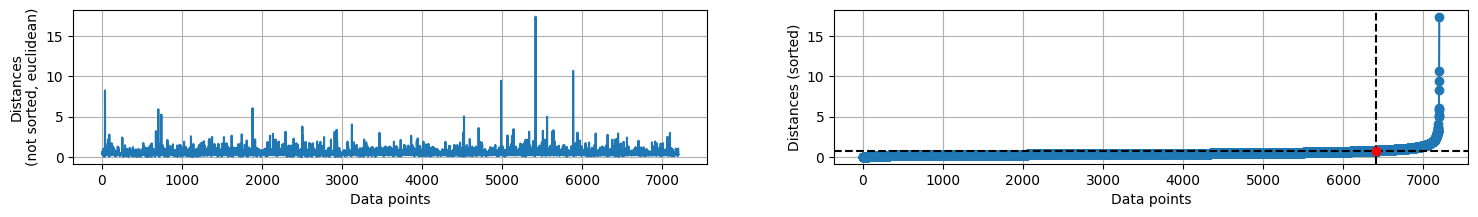

In [71]:
# Apply the algorithm
neighborhood_order = 5

# Find neighborhood
neighborhood_set   = NearestNeighbors(n_neighbors=neighborhood_order, algorithm='ball_tree').fit(df[float_cols])
distances, indices = neighborhood_set.kneighbors(df[float_cols])

# compute distances from 5th nearest neighbors and sort them
dk_sorted     = np.sort(distances[:,-1])
dk_sorted_ind = np.argsort(distances[:,-1])


# Identify the outliers as those points with too high distance from their own 5th nearest neighbor
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, dk_sorted, S=100, curve='convex', direction='increasing', interp_method='polynomial', online=True)     # see other examples: https://kneed.readthedocs.io/en/stable/parameters.html
'''
S - The sensitivity parameter allows us to adjust how aggressive we want Kneedle to be when detecting knees.
    Smaller values for S detect knees quicker, while larger values are more conservative.
    Put simply, S is a measure of how many “flat” points we expect to see in the unmodified data curve before declaring a knee.
'''
knee_x = knee.knee
knee_y = knee.knee_y    # OR: distances[knee.knee]

print([knee_x, np.round(knee_y,2)])


# Plot distances
fig3 = plt.figure(figsize=(18,2))

ax1 = fig3.add_subplot(121)
plt.plot(distances[:,-1])
ax1.set_xlabel('Data points', fontsize=10)
ax1.set_xticks(np.arange(0, N, step=1000))
ax1.set_ylabel('Distances\n(not sorted, %s)' % distance_metric, fontsize=10)
# ax1.title.set_text('Proximity matrix (%s distance)' % distance_metric)
plt.grid()

ax2 = fig3.add_subplot(122)
plt.plot(dk_sorted, 'o-')
ax2.set_xlabel('Data points', fontsize=10)
ax2.set_ylabel('Distances (sorted)', fontsize=10)
plt.axvline(x=knee_x, color='k', linestyle='--')
plt.axhline(y=knee_y, color='k', linestyle='--')
plt.plot((knee_x), (knee_y), 'o', color='r')
plt.grid()

plt.show()

In [28]:
k = 2 # seems to work best with small k. notice how k=1 is not useful as the queried sample will be itself
knn = NearestNeighbors(n_neighbors=k-1, metric='precomputed') # if we query the same points then the first one will be the point itself and ignored by default, so to get k=5 we need to set k=4
knn.fit(prox_mat);

In [29]:
dist, idx= knn.kneighbors()

In [30]:
print(*idx)

[128] [554] [5825] [770] [6488] [5745] [2369] [4722] [5726] [5824] [100] [6111] [1186] [4255] [7087] [3533] [1578] [3146] [3594] [5462] [4465] [70] [4285] [1649] [5928] [5032] [2724] [2945] [5279] [448] [3408] [995] [3775] [1670] [91] [4441] [859] [2022] [39] [38] [3326] [1904] [3947] [2930] [810] [2043] [5770] [6198] [6359] [652] [3487] [5287] [4474] [4768] [6998] [344] [6638] [3370] [3352] [872] [2008] [5858] [1911] [2720] [2028] [1185] [908] [4957] [1791] [1773] [6819] [4202] [171] [1875] [734] [4635] [6787] [5305] [6102] [4859] [4918] [4456] [2069] [3062] [7150] [5708] [3712] [1307] [936] [336] [2297] [34] [2501] [2907] [1614] [890] [2463] [1629] [632] [771] [2521] [947] [4061] [4845] [1978] [1853] [331] [3242] [3965] [685] [1150] [3979] [6150] [793] [6142] [1042] [2703] [1362] [1285] [6264] [5589] [3830] [2249] [4525] [401] [2627] [6162] [5741] [520] [4314] [1980] [373] [1782] [4976] [5608] [2414] [918] [4562] [6914] [583] [1576] [2926] [6814] [2980] [2154] [7050] [278] [3429] [20

In [31]:
knearest = dist[:,k-2]
sort_idx = np.argsort(knearest)

In [32]:
# sort idx based on sort_idx
# be careful not to run it more than once, otherwise the idx will be "sorted" again

idx = idx[sort_idx]
dist = dist[sort_idx]
print(dist)

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.59070337]
 [0.69976049]
 [0.69976049]]


In [33]:
anomaly_perc = 0.01
n_anomalies = int(anomaly_perc*df.shape[0])
anomalies = idx[df.shape[0]-n_anomalies:, -1]

In [34]:
anomalies.shape

(72,)

In [35]:
anomalies

array([2220, 2931, 5507, 1557, 4749, 6736, 6699, 5905, 2069, 1500, 5735,
       6018, 1130, 1275, 3870, 1257, 5507, 3830,  529, 4336, 2687, 3147,
       1209, 5205, 4052, 2919, 2631,   92, 6736, 3731, 1808, 6557,  856,
       5761, 1524, 6166, 5753, 1659, 6302, 4061,  763, 5065, 1746, 4704,
        742, 3783, 2906, 6407, 3066, 1026, 3075, 6373, 4513, 2511, 1336,
       6515, 5316, 3275, 1275,  704, 4522, 4076, 7058,   38,   39,  544,
       3505, 6436, 1112,  704, 5885, 5416])

PCA: explained variation per principal component: [0.35 0.21]

Applying tSNE...


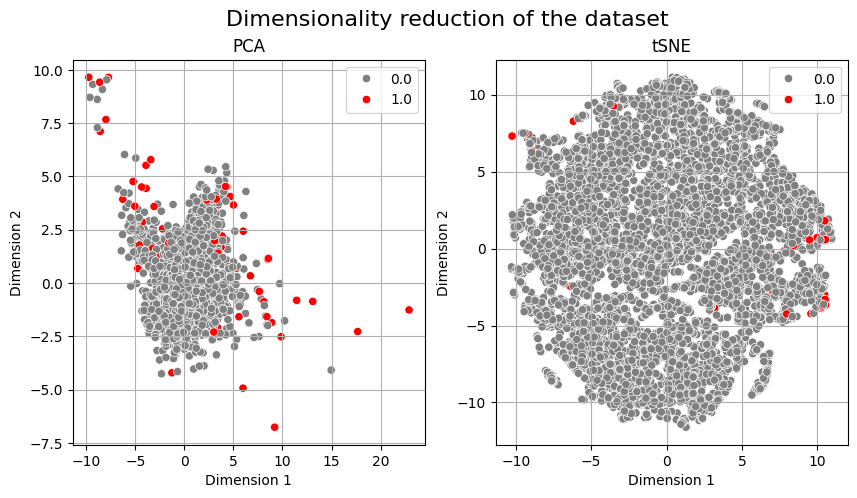

In [36]:
# anomalies visualization
labels = np.zeros(df.shape[0])
labels[anomalies] = 1
PCA_tSNE_visualization(df, 2, labels, ['gray', 'red'])

It seems to work best when k is low, but in any case the results don't seem that great. This might be because we're dealing with a high number of dimensions with respect to the number of samples available.

### Density Based

## Clustering based

### Prototype based clusters: Naive K-Means++
Since we will be using K-means++, to measure the distance between the datapoints and the centroid, by definition it is used the euclidean distance. Hence each boolean column will be interpreted as a float. Although this is a common practice, such a cast leads to losing information. This is why we may call this first approach Naive, as we allow ourselves to loose such knowledge.

**But how would we approach this problem otherwise?**<br>
By rededfining the medoid structure, the distance and the update of the medoid.<br>

__Medoid structure__<br>
Instead of using a cluster defined as a homogeneous array of floats, we will be using an heterogenous one, such that the "representative" for a boolean feature is a boolean, and the "representative" for a float is a float.

__Distance__<br>
For the distance, we will be using the same approach used for computing the proximity matrix in the previous sections. This type of distance is also known as __Gower distance__ with uniform weights.<br>

__Medoid update__<br>
After that we can properly assign each datapoint to its closest medoid and compute the next iteration's medoids.
The classic approach wants to assign to the next iteration centroid the average value of each datapoint of a cluster. 
In our version we keep computing the average for the float features, and the mode for the booleans.


Now we want to pinpoint a few observations that arise from using the __hamming distance__ for boolean features and the __mode__ while updating the medoid.

Computing the mode for boolean feature consists in checking the "label" that has the highest frequency, and a shortcut can be found by considering True as 1 and False as 0 then
$$
    \forall i \in \mathrm{BooleanFeatures} \quad \frac{1}{\vert \mathrm{data} \vert}\sum_{\mathrm{point}\in\mathrm{data}} \mathrm{point}_i = \begin{cases} \mathrm{True} & \mathrm{if }> 0.5\\ \mathrm{False}&\mathrm{else}\end{cases}
$$



So if the boolean features were to be considered as floats, updating the centroid wouldn't be loosing any information if we were to round to the nearest integer after computing such average.

The next observation regards the the hamming distance $h$ and any dissimilarity function $f$ such that $f(x, y) = 0 \Leftrightarrow x=y$, that is satisfied by any Minkowski distance. Now we notice 
$$
    h(x, y) = \begin{cases}1&\mathrm{if}\; x \ne y\\ 0&\mathrm{if}\; x=y\end{cases} \\
    \forall x,y\in\{0,1\}\quad f(x, y) = \begin{cases}1&\mathrm{if}\; x \ne y\\ 0&\mathrm{if}\; x=y\end{cases}
$$ 

In [37]:
def kmeans_gower(data, n_clusters,metrics=None, weights=None, max_iter=300, random_state=None):

    if metrics is None:
        metrics = {np.bool_: 'hamming', np.float64: 'euclidean', float: 'euclidean', bool: 'hamming'}

    # Initialize centroids using k-means++ initialization
    centroids = data.sample(n_clusters, random_state=random_state).values
    bool_indices = [data.columns.get_loc(col) for col in bool_cols]
    float_indices = [data.columns.get_loc(col) for col in float_cols]
    data = data.values

    print(data.shape)
    for _ in tqdm(range(max_iter)):
        # Compute distances from each data point to centroids
        distances = np.array([np.array([gower_distance(point, centroid, metrics, weights) for centroid in centroids]) for point in data])
        
        labels = np.argmin(distances, axis=1)

        new_centroids = centroids.copy() # i need a placeholder and i don't know how to do it
        for k in range(n_clusters):
            cluster_data = data[labels == k]
            len_cluster_data = len(cluster_data)
            new_centroids[k][bool_indices] = np.sum(cluster_data[:, bool_indices], axis=0) / len_cluster_data > .5 # homemade mode
            new_centroids[k][float_indices] = np.mean(cluster_data[:, float_indices], axis=0)

        # Check for convergence, i fucking hate this loosly typed shit
        # if np.allclose(new_centroids[:, float_indices], centroids[:, float_indices]) and (new_centroids[:, bool_indices] == centroids[:, bool_indices]):
        #     break

        centroids = new_centroids
    inertia = np.sum([gower_distance(data[i], centroids[labels[i]], metrics, weights) for i in range (data.shape[0])])
    
    return labels, centroids, inertia



In [38]:
def kmeans_gower_revisited(data, n_clusters, metrics=None, weights=None, max_iter=300, random_state=None, keep_types=False, result_queue=None):
    if metrics is None:
        metrics = {np.bool_: 'hamming', np.float64: 'euclidean', float: 'euclidean', bool: 'hamming'}

    # Initialize centroids using k-means++ initialization
    template = data.sample(n_clusters, random_state=random_state).values
    centroids = data.sample(n_clusters, random_state=random_state).values.astype(float)
    bool_indices = [data.columns.get_loc(col) for col in bool_cols]
    # float_indices = [data.columns.get_loc(col) for col in float_cols]
    data = data.values.astype(float)

    # for _ in tqdm(range(max_iter), desc=f'K-means Gower for {n_clusters}'):
    for _ in range(max_iter):
        # Compute distances from each data point to centroids
        distances = np.array([np.array([np.linalg.norm(centroid - point) for centroid in centroids]) for point in data])
        labels = np.argmin(distances, axis=1)
        pass
        new_centroids = np.array([data[labels == k].mean(axis=0) for k in range(n_clusters)])
        new_centroids[:, bool_indices] = np.round(new_centroids[:, bool_indices])

        if np.allclose(new_centroids, centroids):
            break
        
        centroids = new_centroids
        
    inertia = np.sum([np.linalg.norm(data[i] - centroids[labels[i]]) for i in range (data.shape[0])])

    if keep_types:
        template[:,bool_indices] = centroids[:,bool_indices] > .5
        template[:,not bool_indices] = centroids[:,not bool_indices]
        centroids = template

    if result_queue is not None:
        result_queue.put((labels, centroids, inertia))
    return labels, centroids, inertia

In [39]:
# l, c, i = kmeans_gower(df, 10, max_iter=10)

In [40]:
lr, cr, ir =kmeans_gower_revisited(df, 10, max_iter=20, keep_types=True)
ir

10983.411743663159

PCA: explained variation per principal component: [0.35 0.21 0.14 0.12]

Applying tSNE...


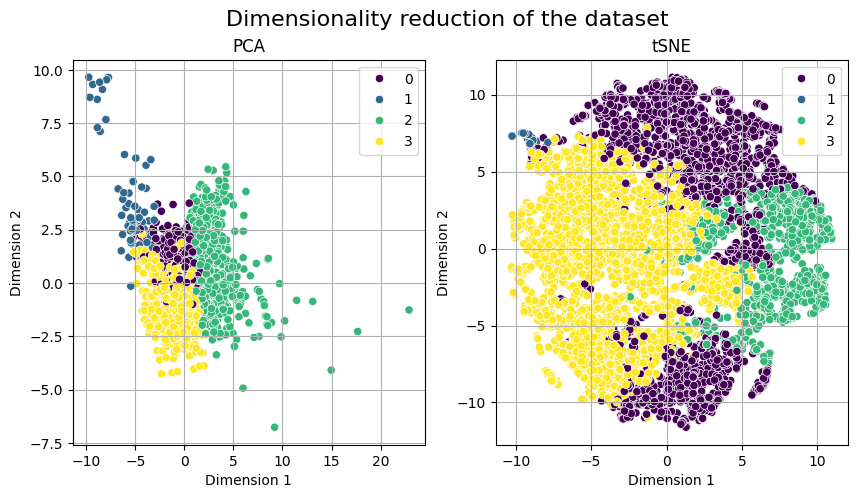

In [41]:
# kmeans++ clustering
nk = 4
kmeans = KMeans(n_clusters=nk, init='k-means++', max_iter=1000, ).fit(df)
labels = kmeans.labels_
# kmeans++ visualization
PCA_tSNE_visualization(df, nk, labels, 'viridis')

#### Elbow method
To find the optimal number of clusters we run the elbow method

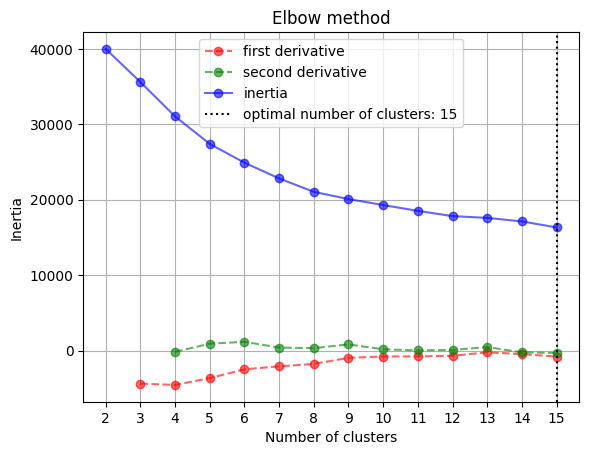

In [42]:
inertia = []
r = range(2,16)
for k in r:
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(df)
    inertia.append(kmeans.inertia_)

#derivative
first_derivative = np.diff(inertia)
second_derivative = np.diff(first_derivative)

# reasoning for the min of second derivative:
# the first derivative is the slope of the inertia, while the second derivative is the acceleration of the inertia
# the "elbow" represents where the inertia starts to decrease at a slower rate, i.e. where the acceleration is the smallest
optimal_k = np.argmin(second_derivative) + 2 + 2 # +2 because we start from 2 clusters and +2 because each derivative is 1 element shorter than the previous one

plt.plot(r[1:], first_derivative, marker='o', color='r', label='first derivative', linestyle='--', alpha=.6)
plt.plot(r[2:], second_derivative, marker='o', color='g', label='second derivative', linestyle='--', alpha=.6)
plt.plot(r, inertia, marker='o', color='b', label='inertia', alpha=.6)
plt.axvline(x=optimal_k, color='black', linestyle='dotted', label='optimal number of clusters: {}'.format(optimal_k))

# plt.axvline(x=???, color='g', linestyle='dotted', label='optimal number of clusters')
plt.xticks(range(2,16))
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.legend()
plt.show()

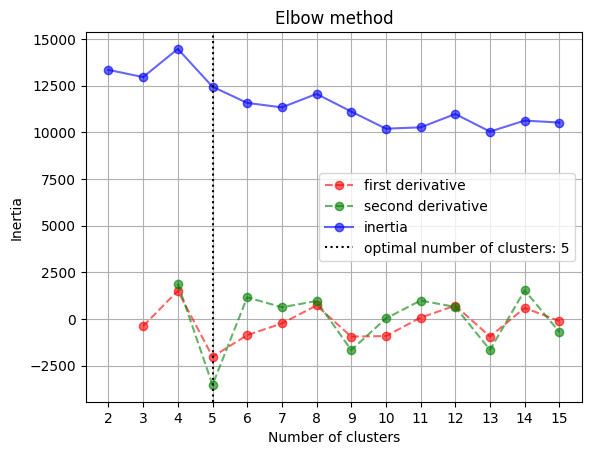

In [43]:
inertia = []
r = range(2,16)
res_queue = queue.Queue()
threads = []

for k in r:
    t = threading.Thread(target=kmeans_gower_revisited, args=(df, k, None, None, 100, None, False, res_queue))
    threads.append(t)

    if len(threads) % 8 == 0:
        for t in threads:
            t.start()
        for t in threads:
            t.join()
        while not res_queue.empty():
            l, c, i = res_queue.get()
            inertia.append(i)
        threads = []
        gc.collect()

# execute the remaining threads
for t in threads:
    t.start()
for t in threads:
    t.join()
while not res_queue.empty():
    l, c, i = res_queue.get()
    inertia.append(i)

    # l, c, i = kmeans_gower_revisited(df, k, max_iter=100)
    # inertia.append(i)

#derivative
first_derivative = np.diff(inertia)
second_derivative = np.diff(first_derivative)

# reasoning for the min of second derivative:
# the first derivative is the slope of the inertia, while the second derivative is the acceleration of the inertia
# the "elbow" represents where the inertia starts to decrease at a slower rate, i.e. where the acceleration is the smallest
optimal_k = np.argmin(second_derivative) + 2 + 2 # +2 because we start from 2 clusters and +2 because each derivative is 1 element shorter than the previous one

plt.plot(r[1:], first_derivative, marker='o', color='r', label='first derivative', linestyle='--', alpha=.6)
plt.plot(r[2:], second_derivative, marker='o', color='g', label='second derivative', linestyle='--', alpha=.6)
plt.plot(r, inertia, marker='o', color='b', label='inertia', alpha=.6)
plt.axvline(x=optimal_k, color='black', linestyle='dotted', label='optimal number of clusters: {}'.format(optimal_k))

# plt.axvline(x=???, color='g', linestyle='dotted', label='optimal number of clusters')
plt.xticks(range(2,16))
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.legend()
plt.show()

In [44]:
inertia = []
r = range(2,16)
res_queue = queue.Queue()
threads = []

with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    for k in r:
        executor.submit(kmeans_gower_revisited, df, k, None, None, 100, None, False, res_queue)
    while not res_queue.empty():
        l, c, i = res_queue.get()
        inertia.append(i)


    # l, c, i = kmeans_gower_revisited(df, k, max_iter=100)
    # inertia.append(i)

#derivative
first_derivative = np.diff(inertia)
second_derivative = np.diff(first_derivative)

# reasoning for the min of second derivative:
# the first derivative is the slope of the inertia, while the second derivative is the acceleration of the inertia
# the "elbow" represents where the inertia starts to decrease at a slower rate, i.e. where the acceleration is the smallest
optimal_k = np.argmin(second_derivative) + 2 + 2 # +2 because we start from 2 clusters and +2 because each derivative is 1 element shorter than the previous one

plt.plot(r[1:], first_derivative, marker='o', color='r', label='first derivative', linestyle='--', alpha=.6)
plt.plot(r[2:], second_derivative, marker='o', color='g', label='second derivative', linestyle='--', alpha=.6)
plt.plot(r, inertia, marker='o', color='b', label='inertia', alpha=.6)
plt.axvline(x=optimal_k, color='black', linestyle='dotted', label='optimal number of clusters: {}'.format(optimal_k))

# plt.axvline(x=???, color='g', linestyle='dotted', label='optimal number of clusters')
plt.xticks(range(2,16))
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.legend()
plt.show()

KeyboardInterrupt: 

If we run the cell above a few times we can clearly notice how the optimal value keeps changing in a range between 5-9. We therefore run it a number of times, say 100, and then plot the frequency of the optimal number of clusters for each run and take the most recurrent.

The number of runs is as high as needed to obtain a consistent result.
Multithreading is applied to significantly speed up the process.

In [ ]:
# 500 runs with 20 clusters takes around 2 minutes (i9-9900K)
def elbow_method_run(k_range, result_queue):
    """
    Runs the elbow method to determine the optimal number of clusters (k) for K-means clustering.

    Parameters:
    k_range (list): A list of integers representing the range of k values to consider.
    result_queue (Queue): A queue to store the optimal k value.

    Returns:
    None, results are stored in result_queue.
    """
    inertia = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++').fit(df)
        inertia.append(kmeans.inertia_)

    # derivative
    first_derivative = np.diff(inertia)
    second_derivative = np.diff(first_derivative)
    optimal_k = np.argmin(second_derivative) + 2 + 2

    result_queue.put(optimal_k)

In [ ]:
def elbow_method_run_gower_revisited(data, k_range, result_queue, max_iter=100, max_workers=8):
    """
    Runs the elbow method using the Gower distance metric to determine the optimal number of clusters.

    Args:
        k_range (list): A list of integers representing the range of values for k (number of clusters).
        result_queue (Queue): A queue to store the result of the optimal k value.

    Returns:
        None, results are stored in the result_queue.
    """
    inertia = []
    local_queue = queue.Queue()
    threads = []
    
    for k in k_range:
        t = threading.Thread(target=kmeans_gower_revisited, args=(data, k, None, None, max_iter, None, False, local_queue))
        threads.append(t)

        if len(threads) % max_workers == 0:
            for t in threads:
                t.start()
            for t in threads:
                t.join()
            while not local_queue.empty():
                l, c, i = local_queue.get()
                inertia.append(i)
            threads = []

    # execute the remaining threads
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    while not local_queue.empty():
        l, c, i = local_queue.get()
        inertia.append(i)

    # derivative
    first_derivative = np.diff(inertia)
    second_derivative = np.diff(first_derivative)
    optimal_k = np.argmin(second_derivative) + 2 + 2

    result_queue.put(optimal_k)

In [ ]:
max_k = 11
optimal_ks = np.zeros(max_k)
runs = 500
threads = []
results = queue.Queue()

# elbow method
for run in tqdm(range(runs)):
    t = threading.Thread(target=elbow_method_run, args=(range(2, max_k), results))
    threads.append(t)
    if len(threads) % 8 == 0:
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()
            optimal_ks[results.get()] += 1
        threads = []
        gc.collect()

# execute the remaining threads
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()
    optimal_ks[results.get()] += 1
    
most_recurrent_k = np.argmax(optimal_ks) + 1
print(f'The most recurrent optimal number of clusters is {most_recurrent_k}')

In [ ]:
# optimal number of clusters histogram
plt.bar(range(1, len(optimal_ks)+1), optimal_ks, alpha=.9)
plt.axvline(x=most_recurrent_k, color='r', linestyle='dotted', alpha=.6)
plt.xlabel('Optimal number of clusters')
plt.ylabel('Frequency')
plt.title('Frequency of optimal number of clusters')
plt.xticks(range(1, max_k+1), rotation='vertical')
plt.show()

In [ ]:
max_k = 11
optimal_ks = np.zeros(max_k)
runs = 50 # our implementations is much slower than the sklearn one, so we can't afford to run too many times, this should take around 4 hours
threads = []
results = queue.Queue()
max_workers = 8
# elbow method
for run in tqdm(range(runs)):
    t = threading.Thread(target=elbow_method_run_gower_revisited, args=(df, range(2, max_k), results, 100, max_workers))
    threads.append(t)
    if len(threads) % max_workers == 0:
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()
            optimal_ks[results.get()] += 1
        threads = []
        gc.collect()

# execute the remaining threads
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()
    optimal_ks[results.get()] += 1
    
most_recurrent_k = np.argmax(optimal_ks) + 1
print(f'The most recurrent optimal number of clusters is {most_recurrent_k}')

Best results are attained with 5-6 clusters 

In [ ]:
kmeans = KMeans(n_clusters=most_recurrent_k, init='k-means++', n_init=1000).fit(df)
labels = kmeans.labels_

# kmeans++ visualization
PCA_tSNE_visualization(df, most_recurrent_k, labels, 'viridis')

In [ ]:
# cluster centers
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(centers, columns=df.columns)
float_df = df.copy()
float_df[bool_cols] = float_df[bool_cols].astype(np.float64)

In [ ]:
float_df.dtypes

In [ ]:
# proximity of the cluster centers
metrics = {np.bool_: 'hamming', np.float64: 'euclidean', float: 'euclidean'}
prox_centers = proximity_matrix_asymmetric(float_df, centers_df, metrics)

In [ ]:
prox_centers

In [ ]:
# TODO: define a threshold for the datapoints that are too far from the cluster centers
# TODO: move cells to have the analysis of the naive kmeans and the elbow method together and then the gower distance kmeans and the elbow method together

----
### Investigation with LOF

In [79]:
# Apply the algorithm
from sklearn.neighbors import LocalOutlierFactor

lof_model  = LocalOutlierFactor(n_neighbors  = neighborhood_order,
                                algorithm='ball_tree',
                                metric='minkowski', p=2,
                                metric_params = None,
                                contamination = 0.05)
# dir(lof_model)
LOF_labels = lof_model.fit_predict(df[float_cols])     # predict the labels (1 inlier, -1 outlier) of X according to LOF
# dir(lof_model)
LOF_values     = lof_model.negative_outlier_factor_
# print(np.round(LOF_values,2))

In [82]:
df

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_11=0,Dim_12=0,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20
Row,,,,,,,,,,,,,,,,,,,,,
0,1.106869,True,False,True,True,True,True,True,False,True,...,True,True,True,True,True,-0.185460,-0.660168,0.293878,-0.829940,0.908303
1,-1.482215,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,-0.200684,1.329573,0.933377,1.842567,-0.144473
2,-0.266928,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,-0.128880,0.533676,-0.206589,1.737765,-0.975611
3,0.631323,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,-0.172405,-0.394869,-0.901688,-0.410723,-0.781670
4,-1.535050,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,-0.200684,0.798975,0.822161,-0.410723,1.102244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.367133,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,-0.102769,0.109203,-0.846071,0.060899,-0.920202
7196,-0.055578,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,4.401598,-1.854013,-2.903570,-0.463130,-2.984192
7197,-0.055578,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,-0.178494,0.016341,-0.540238,-1.615978,0.575847


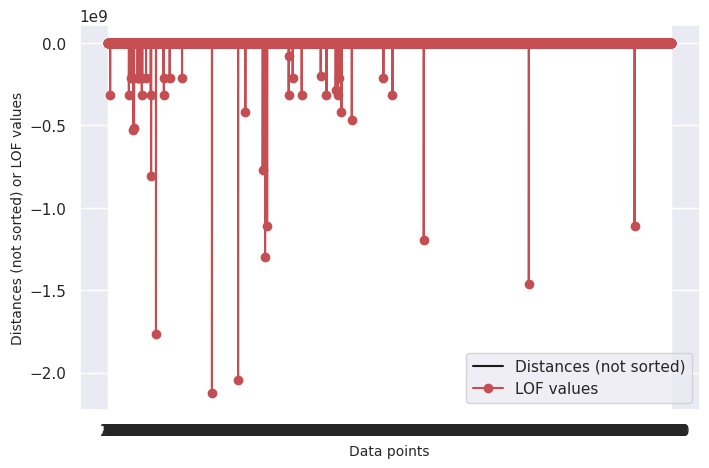

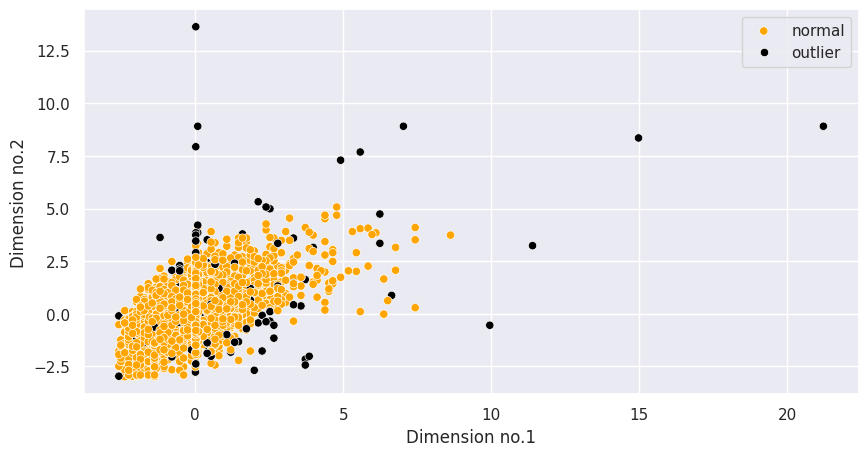

360


In [94]:
# Verify the outlier detection, count and label the outliers

distances, indices = neighborhood_set.kneighbors(df[float_cols])

fig6 = plt.figure('LOF values', figsize=(8,5))
plt.plot(distances[:,-1], 'k-')
plt.xlabel('Data points', fontsize=10)
plt.xticks(np.arange(0, N, step=10))
plt.ylabel('Distances (not sorted) or LOF values', fontsize=10)
plt.plot(LOF_values, 'ro-')
plt.legend(["Distances (not sorted)", "LOF values"])
plt.grid()
plt.show()


fig7 = plt.figure('Scatterplot with the LOF method', figsize=(10,5))
sns.scatterplot( x = df['Dim_17'], y = df['Dim_18'], hue=LOF_labels, palette=['black','orange'])
# sns.scatterplot( x = tsne_results[:,0], y = tsne_results[:,1], hue=LOF_labels, palette=['black','orange'])
# sns.scatterplot( x = pca_results[:,0], y = pca_results[:,1], hue=LOF_labels, palette=['black','orange'])
sns.set_theme(style='dark')
plt.xlabel('Dimension no.1')
plt.ylabel('Dimension no.2')
plt.legend(['normal','outlier'])
plt.grid()
plt.show()


# Count
count4 = len(LOF_labels[LOF_labels==-1])
print(count4)

In [ ]:
y1 = NN_labels2
y2 = LOF_labels

from sklearn import metrics
print(f"Homogeneity: {metrics.homogeneity_score(y1, y2):.3f}")
print(f"Completeness: {metrics.completeness_score(y1, y2):.3f}")
print(f"V-measure: {metrics.v_measure_score(y1, y2):.3f}")
R = metrics.adjusted_rand_score(y1, y2)
print(f"Adjusted Rand Index: {R:.3f}")
print("Adjusted Mutual Information:" f" {metrics.adjusted_mutual_info_score(y1, y2):.3f}")


# Visually inspect the match between the outliers found by the NN and LOF
fig20 = plt.figure('Comparison spotted outliers', figsize=(18,2))
plt.plot(y1, color='blue', marker="o", label='NN')
plt.plot(y2, color='red', marker="x", label='LOF')
plt.xlabel('Data points')
plt.ylabel('Predicted label \n (outlier=-1, normal=1)', fontsize=10)
plt.title('Match on outlier detection between NN and LOF (Rand index = %.2f)' %R)
plt.legend(["NN", "LOF"])
plt.grid()
plt.show()